# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Thermostat dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 96.6 MB/s eta 0:00:00


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time


In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, SOA
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_Thermostat.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_Thermostat.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,633 (248.57 KB)

 Trainable params: 63,533 (248.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4970 - loss: 0.6940 - val_accuracy: 0.4524 - val_loss: 0.6935
Epoch 2/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4967 - loss: 0.6936 - val_accuracy: 0.4524 - val_loss: 0.6935
Epoch 3/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4981 - loss: 0.6939 - val_accuracy: 0.4524 - val_loss: 0.6937
Epoch 4/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4991 - loss: 0.6936 - val_accuracy: 0.4524 - val_loss: 0.6936
Epoch 5/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4998 - loss: 0.6936 - val_accuracy: 0.4524 - val_loss: 0.6938
Epoch 6/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5007 - loss: 0.6939 - val_accuracy: 0.4524 - val_loss: 0.6935
Epoch 7/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5082 - loss: 0.6931 - val_accuracy: 0.4524 - val_loss: 0.6936
Epoch 8/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4977 - loss: 0.6936 - val_accuracy: 0.

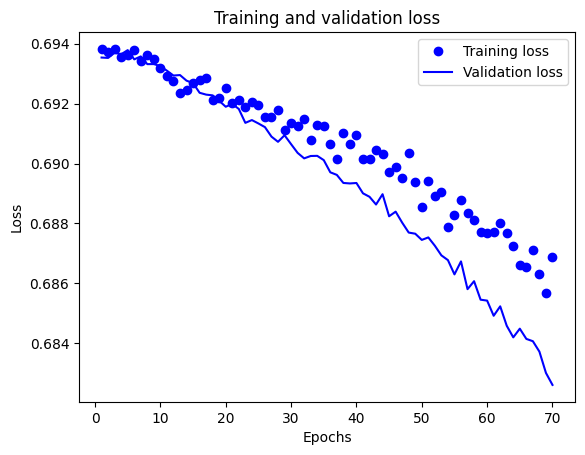

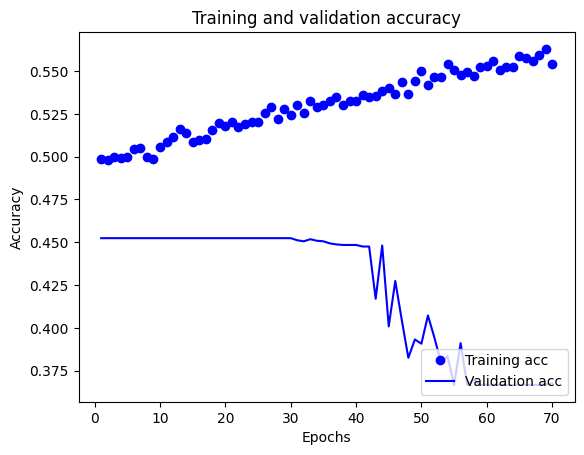


Classification Report
              precision    recall  f1-score   support

           0       0.41      0.78      0.54      1541
           1       0.01      0.00      0.00      1736

    accuracy                           0.37      3277
   macro avg       0.21      0.39      0.27      3277
weighted avg       0.20      0.37      0.25      3277


Confusion Matrix
[[1198  343]
 [1731    5]]


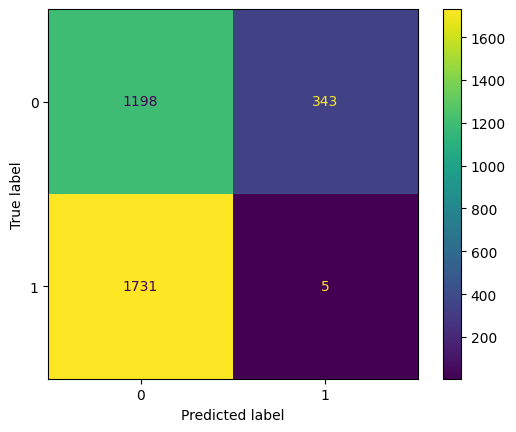

Time taken: 167.2259 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units



*   Dense Layers (** MAY DO IF THERE IS TIME ** )

The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])


#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

#Dense Layer encoder
DENSE_ENCODER = LabelEncoder()
DENSE_ENCODER.fit([5, 8, 10])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]
  #dense_layers = DENSE_ENCODER.inverse_transform([int(params[5])])[0]
  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]

UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = SOA.OriginalSOA(epoch=15, pop_size=20, fc=2)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="seagull-thermo/goc")
model.history.save_local_objectives_chart(filename="seagull-thermo/loc")

model.history.save_global_best_fitness_chart(filename="seagull-thermo/gbfc")
model.history.save_local_best_fitness_chart(filename="seagull-thermo/lbfc")

model.history.save_runtime_chart(filename="seagull-thermo/rtc")

model.history.save_exploration_exploitation_chart(filename="seagull-thermo/eec")

model.history.save_diversity_chart(filename="seagull-thermo/dc")

INFO:mealpy.bio_based.SOA.OriginalSOA:Solving single objective optimization problem.


Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.2507626414299011
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.2858450412750244
Accuracy 0.10860282182693481
Accuracy 0.5997559428215027
Accuracy 0.5475899875164032
Accuracy 0.42037826776504517
Accuracy 0.4524099826812744
Accuracy 0.3895668387413025
Accuracy 0.5475899875164032
Accuracy 0.5356924831867218
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08694326877593994
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.09029895067214966
Accuracy 0.4524099826812744
Accuracy 0.10890787839889526
Accuracy 0.451

INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 1, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 998.82248 seconds


Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.09914582967758179
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08755338191986084


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 2, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 763.09529 seconds


Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.6143990159034729
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.09548503160476685
Accuracy 0.08572298288345337


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 3, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 854.84067 seconds


Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.10433191061019897
Accuracy 0.5363026261329651
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.11622941493988037
Accuracy 0.4524099826812744


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 4, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 960.11349 seconds


Accuracy 0.08572298288345337
Accuracy 0.08785843849182129
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08785843849182129
Accuracy 0.34106165170669556
Accuracy 0.1018913984298706
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.11653447151184082


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 5, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 932.01915 seconds


Accuracy 0.12934714555740356
Accuracy 0.08755338191986084
Accuracy 0.5475899875164032
Accuracy 0.5863331258296967
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.09975594282150269
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08694326877593994
Accuracy 0.09365469217300415
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 6, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 788.96732 seconds


Accuracy 0.113788902759552
Accuracy 0.09304451942443848
Accuracy 0.10768759250640869
Accuracy 0.08572298288345337
Accuracy 0.10951799154281616
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08877366781234741
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08968883752822876
Accuracy 0.11653447151184082
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.4212934970855713
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 7, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 790.91767 seconds


Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.10158634185791016
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.0939597487449646
Accuracy 0.5475899875164032
Accuracy 0.10829776525497437
Accuracy 0.08633315563201904


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 8, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 946.76963 seconds


Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.11897498369216919
Accuracy 0.10128128528594971
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.1143990159034729
Accuracy 0.5475899875164032
Accuracy 0.09731543064117432
Accuracy 0.09670531749725342
Accuracy 0.08572298288345337
Accuracy 0.11958509683609009
Accuracy 0.11653447151184082
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.08724832534790039
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 9, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 575.16618 seconds


Accuracy 0.11409395933151245
Accuracy 0.08633315563201904
Accuracy 0.5433191061019897
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.105857253074646
Accuracy 0.4511897563934326
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.3639414310455322
Accuracy 0.08633315563201904
Accuracy 0.09609520435333252
Accuracy 0.08572298288345337


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 10, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 799.02833 seconds


Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.11470407247543335
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.08999389410018921
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.10280656814575195
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.12812691926956177
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 11, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 1031.55321 seconds


Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.08877366781234741
Accuracy 0.4524099826812744
Accuracy 0.11287373304367065
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.11653447151184082
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 12, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 897.80255 seconds


Accuracy 0.28462475538253784
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.387736439704895
Accuracy 0.1064673662185669
Accuracy 0.4524099826812744
Accuracy 0.4475289583206177
Accuracy 0.11653447151184082
Accuracy 0.5475899875164032
Accuracy 0.08846855163574219
Accuracy 0.5475899875164032


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 13, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 923.18635 seconds


Accuracy 0.08724832534790039
Accuracy 0.08572298288345337
Accuracy 0.08602803945541382
Accuracy 0.13514339923858643
Accuracy 0.11653447151184082
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.10799264907836914
Accuracy 0.5475899875164032


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 14, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 836.08791 seconds


Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08602803945541382
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.09029895067214966
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08694326877593994


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 15, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 690.14576 seconds


Accuracy 0.08572298288345337
Solution: [1.60515648 6.99       5.99       2.99       2.99      ], Fitness: 0.08572298288345337
Solution: [1.60515648 6.99       5.99       2.99       2.99      ], Fitness: 0.08572298288345337


Accuracy 0.08572298288345337
Solution: [1.60515648 6.99       5.99       2.99       2.99      ], Fitness: 0.08572298288345337

Batch Size - 32, **64**, 128

Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, **linear**

Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, **0.1**

Filters - 25, 50, **75**

Hidden Units - 400, 512, **640**

Model: "sequential_323"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_323 (Conv1D)             │ (None, 2, 75)          │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_323               │ (None, 1, 75)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_646 (Dropout)           │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_323         │ (None, 1, 75)          │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_323 (LSTM)                 │ (None, 64)             │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_323 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 640)            │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_647 (Dropout)           │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 1)              │           641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,681 (307.35 KB)

 Trainable params: 78,531 (306.76 KB)

 Non-trainable params: 150 (600.00 B)

Epoch 1/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5323 - loss: 0.6885 - val_accuracy: 0.6123 - val_loss: 0.6170
Epoch 2/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6416 - loss: 0.6352 - val_accuracy: 0.6123 - val_loss: 0.5126
Epoch 3/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7101 - loss: 0.5485 - val_accuracy: 0.7175 - val_loss: 0.4816
Epoch 4/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8037 - loss: 0.4333 - val_accuracy: 0.6159 - val_loss: 0.6307
Epoch 5/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8829 - loss: 0.2964 - val_accuracy: 0.6443 - val_loss: 0.5981
Epoch 6/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9085 - loss: 0.2245 - val_accuracy: 0.8911 - val_loss: 0.5123
Epoch 7/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9249 - loss: 0.1898 - val_accuracy: 0.9045 - val_loss: 0.4868
Epoch 8/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9383 - loss: 0.1556 - val_accuracy: 0.

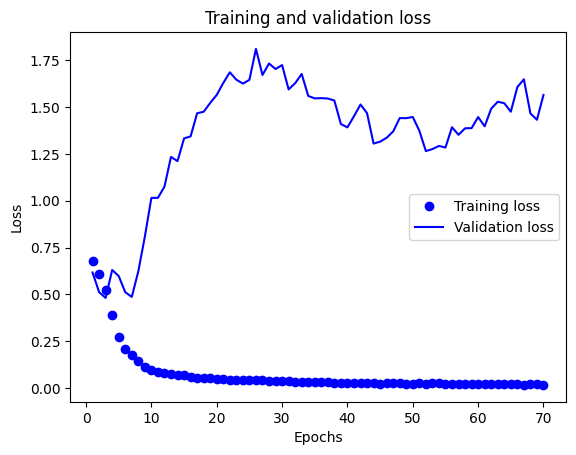

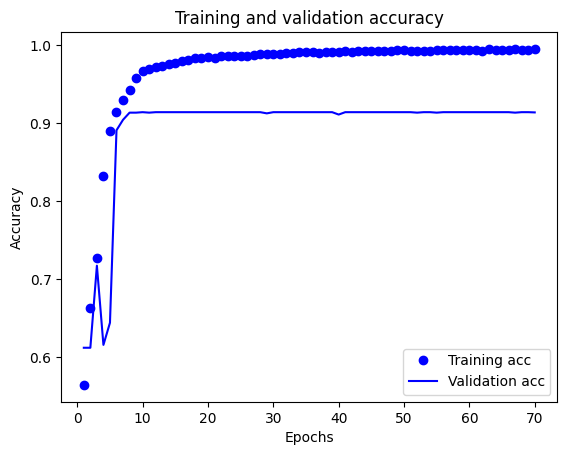


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      1541
           1       0.83      1.00      0.91      1736

    accuracy                           0.89      3277
   macro avg       0.92      0.89      0.89      3277
weighted avg       0.91      0.89      0.89      3277


Confusion Matrix
[[1198  343]
 [   5 1731]]


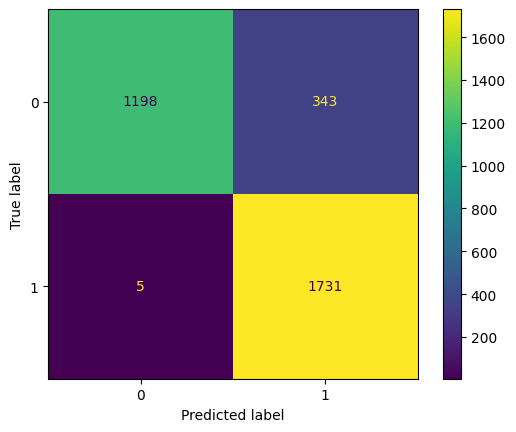

Time taken: 163.1137 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=75, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(640, activation='linear'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.1)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")